# Install Environment

In [100]:
!pip install datasets
!pip install transformers[torch]

import os
import pandas as pd
import torch
import transformers as tr
from datasets import Dataset, load_metric
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import Trainer
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Data Importing

In [75]:
def read_data():
    # GonzaloA data
    gonzaloa_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/train%20Data.csv"
    )  # 24359 row      0 = fake, 1 = real
    gonzaloa_train = gonzaloa_train[["text", "label"]]

    gonzaloa_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/test%20Data.csv"
    )  # 16239 row    0 = fake, 1 = real
    gonzaloa_test = gonzaloa_test[["text", "label"]]

    # pushpdeepfake_news_combined
    pushpdeepfake_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/train.csv"
    )  # 34916 row      0 = fake, 1 = real
    pushpdeepfake_train = pushpdeepfake_train[["text", "label"]]

    pushpdeepfake_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/test.csv"
    )  # 10003 row      0 = fake, 1 = real
    pushpdeepfake_test = pushpdeepfake_test[["text", "label"]]

    # kaggle_datafake
    kaggle_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/kaggle_datafake/kaggle_datafake_train.csv"
    )  # 24000 row      0 = fake, 1 = real
    kaggle_train = kaggle_train[["text", "label"]]

    kaggle_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/kaggle_datafake/kaggle_datafake_test.csv"
    )  # 246669 row     0 = fake, 1 = real
    kaggle_test = kaggle_test[["text", "label"]]

    # news_articles
    news_articles = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/news_articles.csv"
    )  # 2046 row       0 = fake, 1 = real
    news_articles = news_articles[["text", "label"]]

    # mrm8488-fake-news
    mrm8488_fake_news = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/mrm8488-fake-news/fake_news.csv"
    )  # 44919 row    0 = fake, 1 = real

    # ErfanMoosaviMonzzah
    Erfan_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/ErfanMoosaviMonazzah/train.csv"
    )  # 20011 row      0 = fake, 1 = real
    Erfan_train = Erfan_train[["text", "label"]]

    Erfan_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/ErfanMoosaviMonazzah/test.csv"
    )  # 24277 row      0 = fake, 1 = real
    Erfan_test = Erfan_test[["text", "label"]]

    kaggle_competition_train = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/Kaggle-Competition/train.csv"
    )  # 15007 row      0 = fake, 1 = real
    kaggle_competition_train = kaggle_competition_train[["text", "label"]]

    kaggle_competition_test = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/Kaggle-Competition/train.csv"
    )  # 29912 row      0 = fake, 1 = real
    kaggle_competition_test = kaggle_competition_test[["text", "label"]]

    news_articles_cleaned = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/news_articles_cleaned.csv"
    )  # 1659 row       0 = fake, 1 = real
    news_articles_cleaned = news_articles_cleaned[["text", "label"]]

    FAKES = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/FA-KES-Dataset.csv"
    )  # 804 row      0 = fake, 1 = real
    FAKES = FAKES[["text", "label"]]

    news_articles_source = pd.read_csv(
        "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/news_articles_source.csv"
    )  # 2050 row      0 = fake, 1 = real
    news_articles_source = news_articles_source[["text", "label"]]

    return (
        gonzaloa_train,
        gonzaloa_test,
        pushpdeepfake_train,
        pushpdeepfake_test,
        kaggle_train,
        kaggle_test,
        news_articles,
        mrm8488_fake_news,
        Erfan_train,
        Erfan_test,
        kaggle_competition_train,
        kaggle_competition_test,
        news_articles_cleaned,
        FAKES,
        news_articles_source,
    )

In [71]:
(
    gonazaloa_train,
    gonzaloa_test,
    pushpdeepfake_train,
    pushpdeepfake_test,
    kaggle_train,
    kaggle_test,
    news_articles,
    mrm8488_fake_news,
    Erfan_train,
    Erfan_test,
    kaggle_competition_train,
    kaggle_competition_test,
    news_articles_cleaned,
    FAKES,
    news_articles_source,
) = read_data()

<ipython-input-70-df9357a806e3>:8: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168) have mixed types. Specify dtype option on import or set low_memory=False.
  gonzaloa_test = pd.read_csv(
<ipython-input-70-df9357a806e3>:14: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75

# First Trial

## Data Combination

In [ ]:
# combine gonzaloa_train, pushpdeepfake_train
# training_data = pd.concat([gonzaloa_train, pushpdeepfake_train], ignore_index=True)
training_data = Erfan_train

dataset = Dataset.from_pandas(training_data)
dataset = dataset.train_test_split(test_size=0.2)
# dataset["train"]["label"]

## Fine Tuning


In [ ]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(
            x["text"],
            text_target=target_labels,
            return_tensors="pt",
            truncation=True,
            padding=True,
        )
        return token_res

    return apply

In [ ]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

In [ ]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(
    to_tokens, batched=True, remove_columns=["text", "label"]
)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [ ]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [
        tokenizer.decode(p, skip_special_tokens=True)
        for p in predictions.argmax(dim=-1)
    ]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

<ipython-input-11-1bce426d05f6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.548900
1000,0.010900


TrainOutput(global_step=1000, training_loss=0.2799044542312622, metrics={'train_runtime': 495.9284, 'train_samples_per_second': 32.263, 'train_steps_per_second': 2.016, 'total_flos': 2165468823552000.0, 'train_loss': 0.2799044542312622, 'epoch': 1.0})

In [ ]:
# trainer.evaluate()
trainer.save_model()
trainer.save_state()
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"

trainer.save_model(output_dir=final_model_path)

fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)

## Evaluation

### Data Cleaning and sampling

In [ ]:
def clean_sample(df, n):
    temp = df.groupby("label", group_keys=False).apply(lambda x: x.sample(n))
    temp = temp.sample(frac=1, random_state=42)
    temp.dropna(subset=["text", "label"], inplace=True)
    temp["label"].replace({0: "fake", 1: "real"}, inplace=True)
    return temp

In [ ]:
def evaluate_data(df, n=50):
    temp = clean_sample(df, n)

    # Initialize an empty list to store the predictions
    predictions = []

    # Iterate through each row in the DataFrame
    for index, row in temp.iterrows():
        text = row["text"]
        news_report = [text]  # Create a list with the text from the DataFrame

        # Tokenize and generate predictions
        inputs = tokenizer(
            news_report, return_tensors="pt", truncation=True, padding=True
        )
        pred = fine_tuned_model.generate(
            input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]
        )

        # Decode the predictions and store them in the predictions list
        classification = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(classification)

    # Add the predictions to the DataFrame as a new column
    temp["predictions"] = predictions

    classification_rep = classification_report(temp["label"], temp["predictions"])
    print("Classification Report:")
    print(classification_rep)

    accuracy = accuracy_score(temp["label"], temp["predictions"])

    return accuracy

### Evaluation on the samples

In [ ]:
gonzoloa_train_acc = evaluate_data(gonazaloa_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.94      1.00      0.97        50
        real       1.00      0.94      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
gonzoloa_test_acc = evaluate_data(gonzaloa_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97        50
        real       0.96      0.98      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
pushpdeepfake_train_acc = evaluate_data(pushpdeepfake_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:
pushpdeepfake_test_acc = evaluate_data(pushpdeepfake_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.98      0.96        50
        real       0.98      0.94      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [ ]:
kaggle_train_acc = evaluate_data(kaggle_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.15      0.04      0.06        50
        real       0.45      0.78      0.57        50

    accuracy                           0.41       100
   macro avg       0.30      0.41      0.32       100
weighted avg       0.30      0.41      0.32       100



In [ ]:
kaggle_test_acc = evaluate_data(kaggle_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.13      0.04      0.06        50
        real       0.44      0.74      0.55        50

    accuracy                           0.39       100
   macro avg       0.28      0.39      0.30       100
weighted avg       0.28      0.39      0.30       100



In [ ]:
news_articles_acc = evaluate_data(news_articles)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.80      0.66        50
   fake fake       0.00      0.00      0.00         0
        real       0.65      0.35      0.46        48

    accuracy                           0.58        98
   macro avg       0.41      0.38      0.37        98
weighted avg       0.61      0.58      0.56        98



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mrm8488_fake_news_acc = evaluate_data(mrm8488_fake_news)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:
Erfan_train_acc = evaluate_data(Erfan_train)

In [ ]:
Erfan_test_acc = evaluate_data(Erfan_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [ ]:
kaggle_competition_train_acc = evaluate_data(kaggle_competition_train)

In [ ]:
kaggle_competition_test_acc = evaluate_data(kaggle_competition_test)

In [ ]:
news_articles_cleaned_acc = evaluate_data(news_articles_cleaned)

In [ ]:
FAKES_acc = evaluate_data(FAKES)

In [ ]:
news_articles_source_acc = evaluate_data(news_articles_source)

### Bar Chart

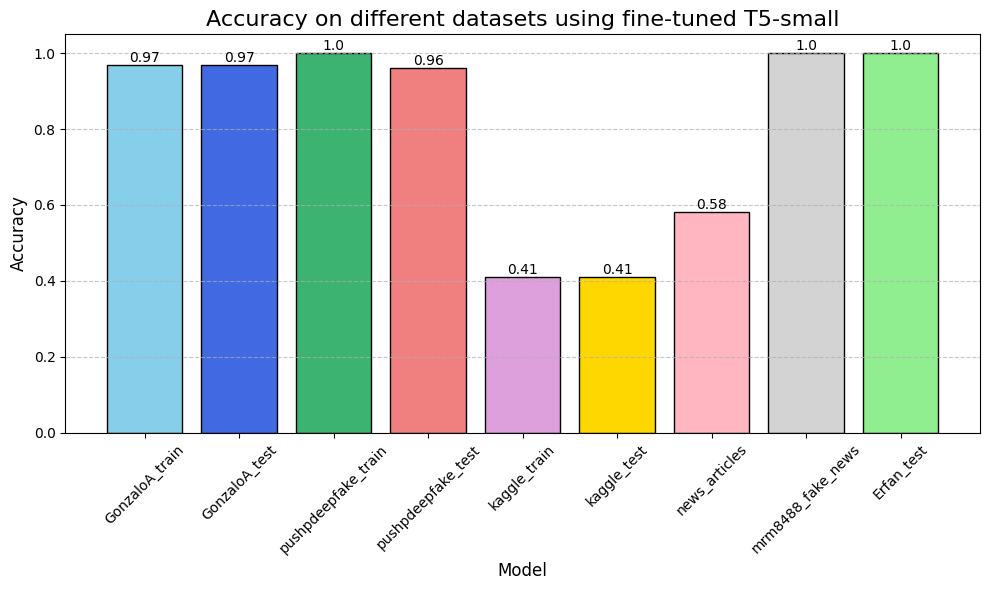

In [ ]:
import matplotlib.pyplot as plt

# Model labels
models = [
    "GonzaloA train",
    "GonzaloA test",
    "pushdeepfake train",
    "pushdeepfake test",
    "Kaggke_train",
    "Kaggle_test",
    "news_articles",
    "mrm8488_fake_news",
    "Erfan_train",
    "Erfan_test",
    "kaggle_competition_train",
    "kaggle_competition_test",
    "news_articles_cleaned",
    "FAKES",
    "news_articles_source",
]

# Accuracy values
accuracies = [gonzoloa_train_acc, gonzoloa_test_acc, pushpdeepfake_train_acc, pushpdeepfake_test_acc, kaggle_train_acc, kaggle_test_acc, news_articles_acc, mrm8488_fake_news_acc, Erfan_test_acc]


# Create a color list to distinguish between 'summ' and non-summ models
colors = ["skyblue",
          "royalblue",
          "mediumseagreen",
          "lightcoral",
          "plum",
          "skyblue",
          "royalblue",
          "mediumseagreen",
          "lightcoral",
          "plum",
          "skyblue",
          "royalblue",
          "mediumseagreen",
          "lightcoral",
          "plum",
]

# Create the bar plot
plt.figure(figsize=(20, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor="black")

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        va="bottom",
        ha="center",
    )

plt.title("Accuracy on different datasets using fine-tuned T5-small", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Second Trial

### Data Importing

### Clean Data

In [ ]:
# GonzaloA data
gonzaloa_train = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/train%20Data.csv"
)  # 24352 row
gonzaloa_train = gonzaloa_train[["text", "label"]]
# gonzaloa_train['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


gonzaloa_test = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/GonzaloA_fake_news/test%20Data.csv"
)  # 16240 row
gonzaloa_test = gonzaloa_test[["text", "label"]]
# gonzaloa_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


# pushpdeepfake_news_combined
pushpdeepfake_train = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/train.csv"
)  # 34916 row
pushpdeepfake_train = pushpdeepfake_train[["text", "label"]]
# clean_2_train['label'].replace({0: 'fake', 1: 'real'}, inplace=True)


pushpdeepfake_test = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/pushpdeepfake_news_combined/test.csv"
)  # 10003 row
pushpdeepfake_test = pushpdeepfake_test[["text", "label"]]
# pushpdeepfake_test['label'].replace({0: 'fake', 1: 'real'}, inplace=True)

### Trash Data

In [ ]:
# kaggle_datafake
kaggle_train = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/kaggle_datafake/kaggle_datafake_train.csv"
)  # 24000 row
kaggle_train = kaggle_train[["text", "label"]]

kaggle_test = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/kaggle_datafake/kaggle_datafake_test.csv"
)  # 208003 row
kaggle_test = kaggle_test[["text", "label"]]

# news_articles
news_articles = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/news_articles.csv"
)  # 2100 row
news_articles = news_articles[["text", "label"]]
news_articles["label"] = news_articles["label"].str.lower()

### New Data

In [ ]:
# mrm8488-fake-news
mrm8488_fake_news = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/mrm8488-fake-news/fake_news.csv"
)  # 44919 row


# ErfanMoosaviMonzzah
Erfan_train = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/ErfanMoosaviMonazzah/train.csv"
)  # 20011 row
Erfan_train = Erfan_train[["text", "label"]]

Erfan_test = pd.read_csv(
    "https://github.com/AnasElbattra/News-Understanding-NLP/raw/main/FAKE-REAL/DATA/ErfanMoosaviMonazzah/test.csv"
)  # 24277 row
Erfan_test = Erfan_test[["text", "label"]]

### Data Combination

In [ ]:
from sklearn.model_selection import train_test_split

news_articles.dropna(subset=["text"], inplace=True)
news_articles["label"].replace({"fake": 0, "real": 1}, inplace=True)
kaggle_train["label"].replace({"fake": 0, "real": 1}, inplace=True)


news_articles_train, news_articles_test = train_test_split(
    news_articles, train_size=1000, random_state=42, stratify=news_articles["label"]
)
training_data = pd.concat(
    [news_articles_train, kaggle_train, Erfan_train], ignore_index=True
)


dataset = Dataset.from_pandas(training_data)
dataset = dataset.train_test_split(test_size=0.2)
# dataset["train"]["label"]

## Fine Tuning


In [ ]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(
            x["text"],
            text_target=target_labels,
            return_tensors="pt",
            truncation=True,
            padding=True,
        )
        return token_res

    return apply

In [ ]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

In [ ]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(
    to_tokens, batched=True, remove_columns=["text", "label"]
)

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [ ]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [ ]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [ ]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [
        tokenizer.decode(p, skip_special_tokens=True)
        for p in predictions.argmax(dim=-1)
    ]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.809400
1000,0.103800
1500,0.075300
2000,0.068300


TrainOutput(global_step=2250, training_loss=0.24157502534654404, metrics={'train_runtime': 1093.5993, 'train_samples_per_second': 32.919, 'train_steps_per_second': 2.057, 'total_flos': 4872304852992000.0, 'train_loss': 0.24157502534654404, 'epoch': 1.0})

In [ ]:
# trainer.evaluate()
trainer.save_model()
trainer.save_state()
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"

trainer.save_model(output_dir=final_model_path)

fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)

## Evaluation

### Data Cleaning and sampling

In [ ]:
# Take 100 samples from each dataset
# gonzaloa_train
gonzaloa_train = gonzaloa_train.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
gonzaloa_train = gonzaloa_train.sample(frac=1, random_state=42)
gonzaloa_train.dropna(subset=["text"], inplace=True)
gonzaloa_train["label"].replace({0: "fake", 1: "real"}, inplace=True)

# gonzaloa_test
gonzaloa_test = gonzaloa_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
gonzaloa_test = gonzaloa_test.sample(frac=1, random_state=42)
gonzaloa_test.dropna(subset=["text"], inplace=True)
gonzaloa_test["label"].replace({0: "fake", 1: "real"}, inplace=True)

# pushpdeepfake_train
pushpdeepfake_train = pushpdeepfake_train.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
pushpdeepfake_train = pushpdeepfake_train.sample(frac=1, random_state=42)
pushpdeepfake_train.dropna(subset=["text"], inplace=True)
pushpdeepfake_train["label"].replace({0: "fake", 1: "real"}, inplace=True)

# pushpdeepfake_test
pushpdeepfake_test = pushpdeepfake_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
pushpdeepfake_test = pushpdeepfake_test.sample(frac=1, random_state=42)
pushpdeepfake_test.dropna(subset=["text"], inplace=True)
pushpdeepfake_test["label"].replace({0: "fake", 1: "real"}, inplace=True)


# kaggle_test
kaggle_test = kaggle_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
kaggle_test = kaggle_test.sample(frac=1, random_state=42)
kaggle_test.dropna(subset=["text"], inplace=True)
kaggle_test["label"].replace({0: "fake", 1: "real"}, inplace=True)

# news_articles
news_articles_test = news_articles_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
news_articles_test = news_articles_test.sample(frac=1, random_state=42)
news_articles_test.dropna(subset=["text"], inplace=True)
news_articles_test["label"].replace({0: "fake", 1: "real"}, inplace=True)

# mrm8488_fake_news
mrm8488_fake_news = mrm8488_fake_news.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
mrm8488_fake_news = mrm8488_fake_news.sample(frac=1, random_state=42)
mrm8488_fake_news.dropna(subset=["text"], inplace=True)
mrm8488_fake_news["label"].replace({0: "fake", 1: "real"}, inplace=True)

# Erfan_test
Erfan_test = Erfan_test.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min(len(x), 50))
)
Erfan_test = Erfan_test.sample(frac=1, random_state=42)
Erfan_test.dropna(subset=["text"], inplace=True)
Erfan_test["label"].replace({0: "fake", 1: "real"}, inplace=True)

In [ ]:
def evaluate_data(df):
    # Initialize an empty list to store the predictions
    predictions = []

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        text = row["text"]
        news_report = [text]  # Create a list with the text from the DataFrame

        # Tokenize and generate predictions
        inputs = tokenizer(
            news_report, return_tensors="pt", truncation=True, padding=True
        )
        pred = fine_tuned_model.generate(
            input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]
        )

        # Decode the predictions and store them in the predictions list
        classification = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(classification)

    # Add the predictions to the DataFrame as a new column
    df["predictions"] = predictions

    classification_rep = classification_report(df["label"], df["predictions"])
    print("Classification Report:")
    print(classification_rep)

    accuracy = accuracy_score(df["label"], df["predictions"])

    return accuracy

### Evaluation on the samples

In [ ]:
gonzaloa_train_accuracy = evaluate_data(gonzaloa_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.96      0.98      0.97        50
        real       0.98      0.96      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
gonzaloa_test_accuracy = evaluate_data(gonzaloa_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.90      0.94        50
        real       0.91      0.98      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [ ]:
pushpdeepfake_train_accuracy = evaluate_data(pushpdeepfake_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.84      0.98      0.91        50
        real       0.98      0.82      0.89        50

    accuracy                           0.90       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.91      0.90      0.90       100



In [ ]:
pushpdeepfake_test_accuracy = evaluate_data(pushpdeepfake_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.94      0.91        50
        real       0.94      0.88      0.91        50

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



In [ ]:
kaggle_test_accuracy = evaluate_data(kaggle_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.94      0.94        50
        real       0.94      0.94      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [ ]:
news_articles_accuracy = evaluate_data(news_articles_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.59      0.68      0.63        50
        real       0.62      0.52      0.57        50

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60      0.60       100



In [ ]:
mrm8488_fake_news_accuracy = evaluate_data(mrm8488_fake_news)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
        fake       0.98      0.96      0.97        50
        real       0.98      0.98      0.98        50

    accuracy                           0.97       100
   macro avg       0.65      0.65      0.65       100
weighted avg       0.98      0.97      0.97       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
erfan_test_accuracy = evaluate_data(Erfan_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.96      0.98        50
        real       0.96      1.00      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



### Bar Chart

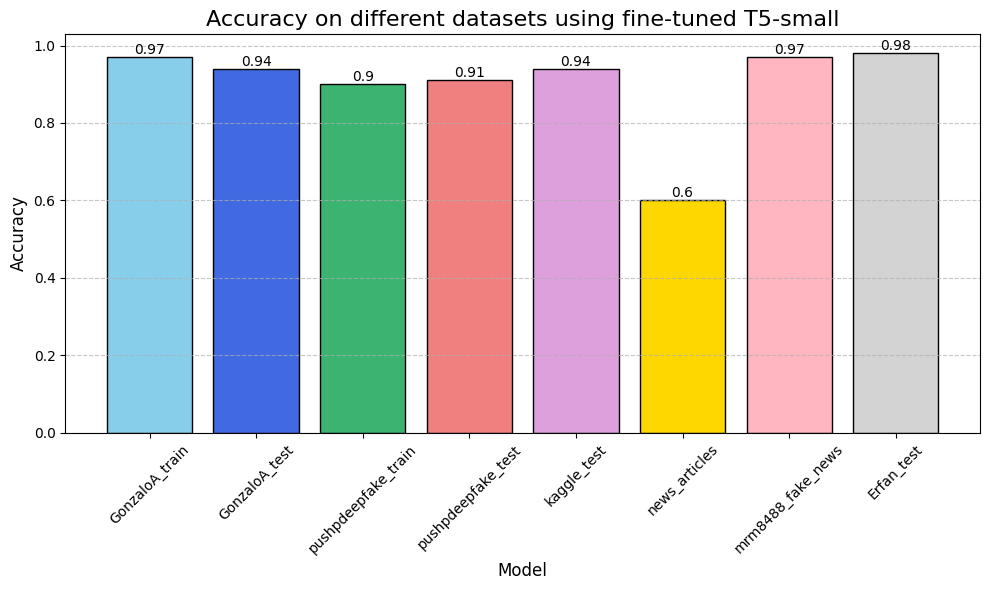

In [ ]:
import matplotlib.pyplot as plt

# Model labels
models = [
    "GonzaloA_train",
    "GonzaloA_test",
    "pushpdeepfake_train",
    "pushpdeepfake_test",
    "kaggle_test",
    "news_articles",
    "mrm8488_fake_news",
    "Erfan_test",
]

# Accuracy values
accuracies = [
    gonzaloa_train_accuracy,
    gonzaloa_test_accuracy,
    pushpdeepfake_train_accuracy,
    pushpdeepfake_test_accuracy,
    kaggle_test_accuracy,
    news_articles_accuracy,
    mrm8488_fake_news_accuracy,
    erfan_test_accuracy,
]

# Create a color list to distinguish between 'summ' and non-summ models
colors = [
    "skyblue",
    "royalblue",
    "mediumseagreen",
    "lightcoral",
    "plum",
    "gold",
    "lightpink",
    "lightgrey",
]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor="black")

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        va="bottom",
        ha="center",
    )

plt.title("Accuracy on different datasets using fine-tuned T5-small", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Try new functions

### Read Data

In [76]:
(
    gonazaloa_train,
    gonzaloa_test,
    pushpdeepfake_train,
    pushpdeepfake_test,
    kaggle_train,
    kaggle_test,
    news_articles,
    mrm8488_fake_news,
    Erfan_train,
    Erfan_test,
    kaggle_competition_train,
    kaggle_competition_test,
    news_articles_cleaned,
    FAKES,
    news_articles_source,
) = read_data()

### Data Combination

In [4]:
training_data = pd.concat([kaggle_train, Erfan_train], ignore_index=True)

dataset = Dataset.from_pandas(training_data)
dataset = dataset.train_test_split(test_size=0.2)
# dataset["train"]["label"]

## Fine Tuning


In [5]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(
            x["text"],
            text_target=target_labels,
            return_tensors="pt",
            truncation=True,
            padding=True,
        )
        return token_res

    return apply

In [6]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

In [7]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(
    to_tokens, batched=True, remove_columns=["text", "label"]
)

Map:   0%|          | 0/35200 [00:00<?, ? examples/s]

Map:   0%|          | 0/8800 [00:00<?, ? examples/s]

In [8]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [9]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [10]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [
        tokenizer.decode(p, skip_special_tokens=True)
        for p in predictions.argmax(dim=-1)
    ]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

<ipython-input-10-1bce426d05f6>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.811800
1000,0.087100
1500,0.062900
2000,0.055700


TrainOutput(global_step=2200, training_loss=0.2359821471300992, metrics={'train_runtime': 1099.4053, 'train_samples_per_second': 32.017, 'train_steps_per_second': 2.001, 'total_flos': 4764031411814400.0, 'train_loss': 0.2359821471300992, 'epoch': 1.0})

In [12]:
# trainer.evaluate()
trainer.save_model()
trainer.save_state()
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"

trainer.save_model(output_dir=final_model_path)

fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)

## Evaluation

### Data Cleaning and sampling

In [77]:
def clean_sample(df, n):
    temp = df.groupby("label", group_keys=False).apply(lambda x: x.sample(n))
    temp = temp.sample(frac=1, random_state=42)
    temp.dropna(subset=["text", "label"], inplace=True)
    temp["label"].replace({0: "fake", 1: "real"}, inplace=True)
    return temp

In [78]:
def evaluate_data(df, n=50):
    temp = clean_sample(df, n=50)

    # Initialize an empty list to store the predictions
    predictions = []

    # Iterate through each row in the DataFrame
    for index, row in temp.iterrows():
        text = row["text"]
        news_report = [text]  # Create a list with the text from the DataFrame

        # Tokenize and generate predictions
        inputs = tokenizer(
            news_report, return_tensors="pt", truncation=True, padding=True
        )
        pred = fine_tuned_model.generate(
            input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]
        )

        # Decode the predictions and store them in the predictions list
        classification = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(classification)

    # Add the predictions to the DataFrame as a new column
    temp["predictions"] = predictions

    classification_rep = classification_report(temp["label"], temp["predictions"])
    print("Classification Report:")
    print(classification_rep)

    accuracy = accuracy_score(temp["label"], temp["predictions"])

    return accuracy

### Evaluation on the samples

In [60]:
gonzoloa_train_acc = evaluate_data(gonazaloa_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.90      0.94        50
        real       0.91      0.98      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



In [81]:
gonzoloa_test_acc = evaluate_data(gonzaloa_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.92      0.92        50
        real       0.92      0.92      0.92        50

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



In [82]:
pushpdeepfake_train_acc = evaluate_data(pushpdeepfake_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.79      0.96      0.86        50
        real       0.95      0.74      0.83        50

    accuracy                           0.85       100
   macro avg       0.87      0.85      0.85       100
weighted avg       0.87      0.85      0.85       100



In [83]:
pushpdeepfake_test_acc = evaluate_data(pushpdeepfake_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.82      1.00      0.90        50
        real       1.00      0.78      0.88        50

    accuracy                           0.89       100
   macro avg       0.91      0.89      0.89       100
weighted avg       0.91      0.89      0.89       100



In [84]:
# kaggle_train_acc = evaluate_data(kaggle_train)

In [85]:
kaggle_test_acc = evaluate_data(kaggle_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      0.98      0.99        50
        real       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [86]:
news_articles_acc = evaluate_data(news_articles)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.86      0.12      0.21        50
        real       0.53      0.98      0.69        50

    accuracy                           0.55       100
   macro avg       0.69      0.55      0.45       100
weighted avg       0.69      0.55      0.45       100



In [87]:
mrm8488_fake_news_acc = evaluate_data(mrm8488_fake_news)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
        fake       1.00      0.98      0.99        50
        real       1.00      1.00      1.00        50

    accuracy                           0.99       100
   macro avg       0.67      0.66      0.66       100
weighted avg       1.00      0.99      0.99       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
# Erfan_train_acc = evaluate_data(Erfan_train)

In [89]:
Erfan_test_acc = evaluate_data(Erfan_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.94      1.00      0.97        50
        real       1.00      0.94      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [90]:
kaggle_competition_train_acc = evaluate_data(kaggle_competition_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.98      0.96        50
        real       0.98      0.94      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



In [91]:
kaggle_competition_test_acc = evaluate_data(kaggle_competition_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.98      0.98        50
        real       0.98      0.98      0.98        50

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [92]:
news_articles_cleaned_acc = evaluate_data(news_articles_cleaned)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.56      0.10      0.17        50
        real       0.51      0.92      0.65        50

    accuracy                           0.51       100
   macro avg       0.53      0.51      0.41       100
weighted avg       0.53      0.51      0.41       100



In [93]:
FAKES_acc = evaluate_data(FAKES)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.42      0.10      0.16        50
        real       0.49      0.86      0.62        50

    accuracy                           0.48       100
   macro avg       0.45      0.48      0.39       100
weighted avg       0.45      0.48      0.39       100



In [94]:
news_articles_source_acc = evaluate_data(news_articles_source)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
        fake       0.55      0.12      0.20        50
        real       0.50      0.88      0.64        50

    accuracy                           0.50       100
   macro avg       0.35      0.33      0.28       100
weighted avg       0.52      0.50      0.42       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bar Chart

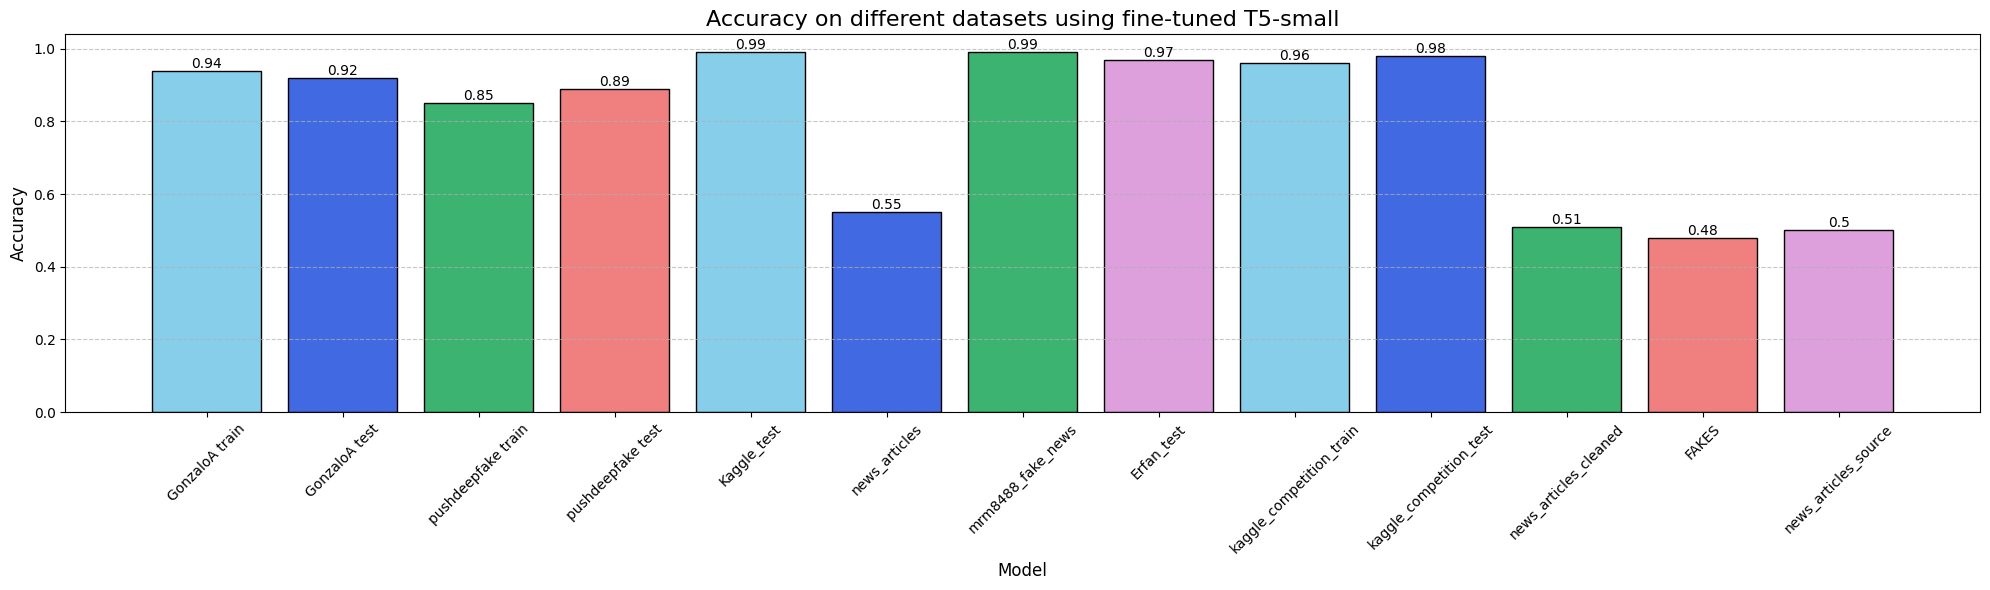

In [95]:
# Model labels
models = [
    "GonzaloA train",
    "GonzaloA test",
    "pushdeepfake train",
    "pushdeepfake test",
    # "Kaggke_train",
    "Kaggle_test",
    "news_articles",
    "mrm8488_fake_news",
    # "Erfan_train",
    "Erfan_test",
    "kaggle_competition_train",
    "kaggle_competition_test",
    "news_articles_cleaned",
    "FAKES",
    "news_articles_source",
]

# Accuracy values
accuracies = [
    gonzoloa_train_acc,
    gonzoloa_test_acc,
    pushpdeepfake_train_acc,
    pushpdeepfake_test_acc,
    # kaggle_train_acc,
    kaggle_test_acc,
    news_articles_acc,
    mrm8488_fake_news_acc,
    # Erfan_train_Acc,
    Erfan_test_acc,
    kaggle_competition_train_acc,
    kaggle_competition_test_acc,
    news_articles_cleaned_acc,
    FAKES_acc,
    news_articles_source_acc,
]

# Create a color list to distinguish between 'summ' and non-summ models
colors = ["skyblue",
          "royalblue",
          "mediumseagreen",
          "lightcoral",
        #   "plum",
          "skyblue",
          "royalblue",
          "mediumseagreen",
        #   "lightcoral",
          "plum",
          "skyblue",
          "royalblue",
          "mediumseagreen",
          "lightcoral",
          "plum",
]

# Create the bar plot
plt.figure(figsize=(20, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor="black")

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        va="bottom",
        ha="center",
    )

plt.title("Accuracy on different datasets using fine-tuned T5-small", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Third Trial

In [105]:
(
    gonazaloa_train,
    gonzaloa_test,
    pushpdeepfake_train,
    pushpdeepfake_test,
    kaggle_train,
    kaggle_test,
    news_articles,
    mrm8488_fake_news,
    Erfan_train,
    Erfan_test,
    kaggle_competition_train,
    kaggle_competition_test,
    news_articles_cleaned,
    FAKES,
    news_articles_source,
) = read_data()

### Data Combination

In [106]:
news_articles_train, news_articles_test = train_test_split(news_articles, train_size=800, shuffle=True)
news_articles_source_train, news_articles_source_test = train_test_split(news_articles_source, train_size=800, shuffle=True)


training_data = pd.concat([news_articles_train, news_articles_source_train, kaggle_train, Erfan_train], ignore_index=True)

dataset = Dataset.from_pandas(training_data)
dataset = dataset.train_test_split(test_size=0.2)
# dataset["train"]["label"]

## Fine Tuning


In [107]:
def to_tokens(tokenizer, label_map):
    def apply(x):
        target_labels = [label_map[y] for y in x["label"]]
        token_res = tokenizer(
            x["text"],
            text_target=target_labels,
            return_tensors="pt",
            truncation=True,
            padding=True,
        )
        return token_res

    return apply

In [108]:
tokenizer = tr.AutoTokenizer.from_pretrained("t5-small")

In [109]:
label_lookup = {0: "fake", 1: "real"}
to_tokens = to_tokens(tokenizer, label_lookup)
tokenized_dataset = dataset.map(
    to_tokens, batched=True, remove_columns=["text", "label"]
)

Map:   0%|          | 0/36472 [00:00<?, ? examples/s]

Map:   0%|          | 0/9118 [00:00<?, ? examples/s]

In [110]:
local_training_root = "./"
checkpoint_name = "test-trainer"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)
training_args = tr.TrainingArguments(
    local_checkpoint_path,
    num_train_epochs=1,  # default number of epochs to train is 3
    per_device_train_batch_size=16,
    optim="adamw_torch",
    report_to=["tensorboard"],
)

In [111]:
t5_model = tr.AutoModelForSeq2SeqLM.from_pretrained("t5-small")

In [112]:
metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = [
        tokenizer.decode(p, skip_special_tokens=True)
        for p in predictions.argmax(dim=-1)
    ]
    labels = [label_lookup[l] for l in labels]

    return metric.compute(predictions=predictions, references=labels)

In [113]:
trainer = Trainer(
    model=t5_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss
500,0.837100
1000,0.113300
1500,0.085100
2000,0.077900


TrainOutput(global_step=2280, training_loss=0.25256315616139197, metrics={'train_runtime': 1174.7024, 'train_samples_per_second': 31.048, 'train_steps_per_second': 1.941, 'total_flos': 4936186183286784.0, 'train_loss': 0.25256315616139197, 'epoch': 1.0})

In [114]:
# trainer.evaluate()
trainer.save_model()
trainer.save_state()
checkpoint_name = "test-trainer-deepspeed"
final_model_path = f"./llm04_fine_tuning/{checkpoint_name}"

trainer.save_model(output_dir=final_model_path)

fine_tuned_model = tr.AutoModelForSeq2SeqLM.from_pretrained(final_model_path)

## Evaluation

### Data Cleaning and sampling

In [115]:
def clean_sample(df, n):
    temp = df.groupby("label", group_keys=False).apply(lambda x: x.sample(n))
    temp = temp.sample(frac=1, random_state=42)
    temp.dropna(subset=["text", "label"], inplace=True)
    temp["label"].replace({0: "fake", 1: "real"}, inplace=True)
    return temp

In [116]:
def evaluate_data(df, n=50):
    temp = clean_sample(df, n=50)

    # Initialize an empty list to store the predictions
    predictions = []

    # Iterate through each row in the DataFrame
    for index, row in temp.iterrows():
        text = row["text"]
        news_report = [text]  # Create a list with the text from the DataFrame

        # Tokenize and generate predictions
        inputs = tokenizer(
            news_report, return_tensors="pt", truncation=True, padding=True
        )
        pred = fine_tuned_model.generate(
            input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"]
        )

        # Decode the predictions and store them in the predictions list
        classification = tokenizer.batch_decode(pred, skip_special_tokens=True)[0]
        predictions.append(classification)

    # Add the predictions to the DataFrame as a new column
    temp["predictions"] = predictions

    classification_rep = classification_report(temp["label"], temp["predictions"])
    print("Classification Report:")
    print(classification_rep)

    accuracy = accuracy_score(temp["label"], temp["predictions"])

    return accuracy

### Evaluation on the samples

In [117]:
gonzoloa_train_acc = evaluate_data(gonazaloa_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.96      0.90      0.93        50
        real       0.91      0.96      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [118]:
gonzoloa_test_acc = evaluate_data(gonzaloa_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97        50
        real       0.96      0.98      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [119]:
pushpdeepfake_train_acc = evaluate_data(pushpdeepfake_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.88      0.98      0.92        50
        real       0.98      0.86      0.91        50

    accuracy                           0.92       100
   macro avg       0.93      0.92      0.92       100
weighted avg       0.93      0.92      0.92       100



In [120]:
pushpdeepfake_test_acc = evaluate_data(pushpdeepfake_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.98      0.93        50
        real       0.98      0.88      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



In [121]:
# kaggle_train_acc = evaluate_data(kaggle_train)

In [122]:
kaggle_test_acc = evaluate_data(kaggle_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.98      0.96      0.97        50
        real       0.96      0.98      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [123]:
news_articles_acc = evaluate_data(news_articles_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.58      0.70      0.64        50
        real       0.62      0.50      0.56        50

    accuracy                           0.60       100
   macro avg       0.60      0.60      0.60       100
weighted avg       0.60      0.60      0.60       100



In [124]:
mrm8488_fake_news_acc = evaluate_data(mrm8488_fake_news)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
        fake       0.96      0.94      0.95        50
        real       1.00      0.96      0.98        50

    accuracy                           0.95       100
   macro avg       0.65      0.63      0.64       100
weighted avg       0.98      0.95      0.96       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
# Erfan_train_acc = evaluate_data(Erfan_train)

In [126]:
Erfan_test_acc = evaluate_data(Erfan_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00        50
        real       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [127]:
kaggle_competition_train_acc = evaluate_data(kaggle_competition_train)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
        fake       0.96      0.96      0.96        50
        real       0.98      0.96      0.97        50

    accuracy                           0.96       100
   macro avg       0.65      0.64      0.64       100
weighted avg       0.97      0.96      0.96       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [128]:
kaggle_competition_test_acc = evaluate_data(kaggle_competition_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
        fake       0.94      0.94      0.94        50
        real       0.98      0.94      0.96        50

    accuracy                           0.94       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.96      0.94      0.95       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
news_articles_cleaned_acc = evaluate_data(news_articles_cleaned)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.62      0.74      0.67        50
        real       0.68      0.54      0.60        50

    accuracy                           0.64       100
   macro avg       0.65      0.64      0.64       100
weighted avg       0.65      0.64      0.64       100



In [130]:
FAKES_acc = evaluate_data(FAKES)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.25      0.04      0.07        50
        real       0.48      0.88      0.62        50

    accuracy                           0.46       100
   macro avg       0.36      0.46      0.34       100
weighted avg       0.36      0.46      0.34       100



In [131]:
news_articles_source_acc = evaluate_data(news_articles_source_test)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        fake       0.50      0.58      0.54        50
        real       0.50      0.42      0.46        50

    accuracy                           0.50       100
   macro avg       0.50      0.50      0.50       100
weighted avg       0.50      0.50      0.50       100



### Bar Chart

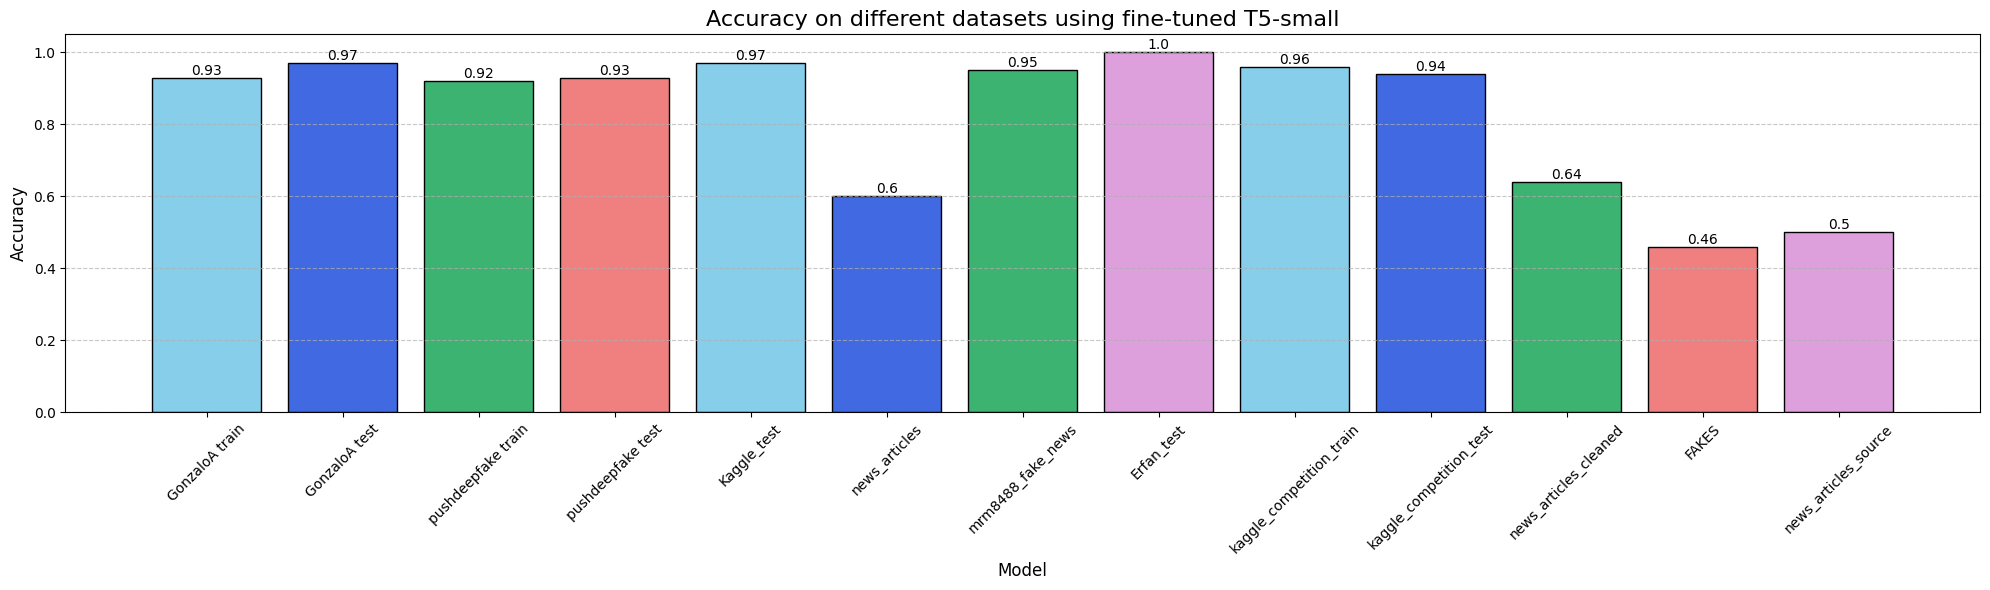

In [132]:
# Model labels
models = [
    "GonzaloA train",
    "GonzaloA test",
    "pushdeepfake train",
    "pushdeepfake test",
    # "Kaggke_train",
    "Kaggle_test",
    "news_articles",
    "mrm8488_fake_news",
    # "Erfan_train",
    "Erfan_test",
    "kaggle_competition_train",
    "kaggle_competition_test",
    "news_articles_cleaned",
    "FAKES",
    "news_articles_source",
]

# Accuracy values
accuracies = [
    gonzoloa_train_acc,
    gonzoloa_test_acc,
    pushpdeepfake_train_acc,
    pushpdeepfake_test_acc,
    # kaggle_train_acc,
    kaggle_test_acc,
    news_articles_acc,
    mrm8488_fake_news_acc,
    # Erfan_train_Acc,
    Erfan_test_acc,
    kaggle_competition_train_acc,
    kaggle_competition_test_acc,
    news_articles_cleaned_acc,
    FAKES_acc,
    news_articles_source_acc,
]

# Create a color list to distinguish between 'summ' and non-summ models
colors = ["skyblue",
          "royalblue",
          "mediumseagreen",
          "lightcoral",
        #   "plum",
          "skyblue",
          "royalblue",
          "mediumseagreen",
        #   "lightcoral",
          "plum",
          "skyblue",
          "royalblue",
          "mediumseagreen",
          "lightcoral",
          "plum",
]

# Create the bar plot
plt.figure(figsize=(20, 6))
bars = plt.bar(models, accuracies, color=colors, edgecolor="black")

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        round(yval, 2),
        va="bottom",
        ha="center",
    )

plt.title("Accuracy on different datasets using fine-tuned T5-small", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Adding a grid
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()